In [1]:
import numpy as np
from quantecon.optimize import brentq
from interpolation import interp
from numba import njit, jitclass, float64
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

## The Optimal Savings Problem


<a id='index-1'></a>
Let’s write down the model and then discuss how to solve it.

### Set-Up

Consider a household that chooses a state-contingent consumption plan $ \{c_t\}_{t \geq 0} $ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to


<a id='equation-eqst'></a>
$$
a_{t+1} \leq  R(a_t-c_t)  + y_{t+1},
\qquad c_t \geq 0,
\qquad a_t \geq 0
\qquad t = 0, 1, \ldots
$$

Note: above diverges in timing from current model in ifp. 

Here

- $ \beta \in (0,1) $ is the discount factor  
- $ a_t $ is asset holdings at time $ t $ is nonnegative, $ a_t \geq 0 $  
- $ c_t $ is consumption  
- $ z_t $ is the state that determines non-capital income
- $ y_t $ is non-capital income (wages, unemployment compensation, etc.)  
- $ R := 1 + r $, where $ r > 0 $ is the interest rate on savings  


State $ \{z_t\} $ is assumed to be a Markov process taking values in $ Z\subset (0,\infty) $ with stochastic kernel $ \Pi $.

This means that $ \Pi(z, B) $ is the probability that $ z_{t+1} \in
B $ given $ z_t = z $.

The expectation of $ f(z_{t+1}) $ given $ z_t = z $ is written as

$$
\int f( \acute z) \, \Pi(z, d \acute z)
$$

We further assume that

1. $ r > 0 $ and $ \beta R < 1 $  
1. $ u $ is smooth, strictly increasing and strictly concave with $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  


The asset space is $ [0, \infty) $ and the state is the pair $ (a,z) \in S := [0,\infty) \times Z $.

A *feasible consumption path* from $ (a,z) \in S $ is a consumption
sequence $ \{c_t\} $ such that $ \{c_t\} $ and its induced asset path $ \{a_t\} $ satisfy

1. $ (a_0, z_0) = (a, z) $  
1. the feasibility constraints in [(1)](ifp_advanced.ipynb#equation-eqst), and  
1. measurability of $ c_t $ w.r.t. the filtration generated by $ \{z_1, \ldots, z_t\} $  


The meaning of the third point is just that consumption at time $ t $ can only be
a function of outcomes that have already been observed.

### Euler Equation

The value function of this problem is

$$
v(a, z)
= \max_{0 \leq c \leq a }
\left\{
    u(c) + \beta \int v(R(a-c) + y^{\prime} , z^{\prime}) \Pi(z, d \acute z)
\right\}
$$

First, let's consider the case of interior solution. Taking first derivative with respect to control $c$ implies

$$
u^{\prime}\left(c\right)=\beta R\int v_{a}\left(R\left(a-c\right)+y^{\prime},z^{\prime}\right)\prod\left(z,dz^{\prime}\right)
$$

and $v_{a}\left(a,z\right)$ is given by taking differential and using envelope theorem

$$
v_{a}\left(a,z\right)=\beta R\int v_{a}\left(R\left(a-c\right)+y^{\prime},z^{\prime}\right)\prod\left(z,d^{\prime}\right)
$$

Combining these two optimality conditions implies that an interior solution $c$ must satisfies

$$
u^{\prime}\left(c\right)=\beta R\int u^{\prime}\left(c^{\prime}\right)\prod\left(z,dz^{\prime}\right)
$$

If it's corner solution, then we have

$$
u^{\prime}\left(c\right) = u^{\prime}\left(a\right)
$$

Therefore, the Euler equation is

$$
u^{\prime}\left(c\right)=\max \{\beta R\int u^{\prime}\left(c^{\prime}\right)\prod\left(z,dz^{\prime}\right), u^{\prime}\left(a\right)\}
$$

Denoting $\sigma^*\left(a,z\right)$ as the optimal policy function, it must satisfy the following functional equality

$$
u^{\prime}\circ\sigma^{*}\left(a,z\right)=\max\{\beta R\int u^{\prime}\circ\sigma^{*}\left(R\left(a-\sigma^{*}\left(a,z\right)\right)+y^{\prime},z^{\prime}\right)\prod\left(z,dz^{\prime}\right), u^{\prime}\left(a\right)\}
$$

## Computation


This lecture will introduce you two methods of solving for $ \sigma^* $

1. Time iteration (TI) using the Euler equality  
1. Endogenous Grid Method

### Time Iteration

Given an initial guess $\sigma_0\left(c\right)$, we apply the following functional operator until it converges.


<a id='equation-eqeul1'></a>
$$
u' \circ \sigma_{k+1} (a, z)
= \max \left\{
\beta R \int u' \circ \sigma_{k} \, \{R (a - \sigma_{k+1}(a, z)) + z^\prime, \, z^\prime\}
\, \Pi(z,d z^\prime)
\, , \;
     u'(a)
     \right\}
$$

where $ u' \circ \sigma(s) := u'(\sigma(s)) $ and the subscript $k$ is the number of iterations.

Since $u^\prime:\mathcal{R}\rightarrow\mathcal{R}$ is a one-to-one mapping, we can apply the inverse of $u^\prime$ on both sides of the time iteration equation,

$$
\sigma_{k+1} (a, z)
= K^{euler} \sigma_{k}
= \min \left\{
\left(u^{\prime}\right)^{-1}\{\beta R \int u' \circ \sigma_{k} \, \{R (a - \sigma_{k+1}(a, z)) + z^\prime, \, z^\prime\}
\, \Pi(z,d z^\prime)\}
\, , \;
     a
     \right\}
$$

where $K^{euler}$ is the policy function operator. Note that we are now taking minimum since $u^\prime$ is decreasing in $c$.

Note that $\sigma_{k+1}(a, z)$ appears on both sides of the equality, which means each iteration involves root-finding of $\sigma_{k+1}(a, z)$.

Replacing $a-\sigma\left(a,z\right)$ with capital $k$, The following part on the right hand side

$$
\left(u^{\prime}\right)^{-1} \{\beta R \int u' \circ \sigma_{k} \, \{R k + z^\prime, \, z^\prime\}
\, \Pi(z,d z^\prime)\}
$$

implies that the optimal consumption today can be suggested by $(k, z)$ independently of $a$ when $c^*<a$. In the code implementation, we defined a function `k_z_optimal_c` to compute this "unbounded" $(k,z)$-optimal consumption.

### Endogenous Grid Method

Endogenous grid method can avoid root-finding which is costly due to a significant number of function evaluations by adjusting the state grid of asset $a$ at each iteration.

Instead of updating optimal consumtion at each $a$ grid point, we fix a exogenous grid for capital $k=a-c$ and compute the $(k,z)$-optimal consumption.

$$
\hat{\sigma}(k,z) = {u^{\prime}}^{-1} \beta R \int u' \circ \sigma_{k} \, \{R k + z^\prime, \, z^\prime\}
\, \Pi(z,d z^\prime)
$$

$\hat{\sigma}(k,z)$ is the optimal consumption for $\left(a,z\right)$ where $a=k+\hat{\sigma}(k,z)$, which implies $\sigma_{k+1}(k+\hat{\sigma}(k,z),z) = \hat{\sigma}(k,z)$. We denote $K^{EGM}$ as the operator that updates $\sigma_k$ using this endogenous grid method.

# Implementation

### Set-Up

In [2]:
ifp_data = [
    ('γ', float64),              # Utility parameter 
    ('r', float64),              # Interest rate
    ('β', float64),              # Discount factor
    ('Π', float64[:, :]),        # Markov matrix for z_t
    ('y_vals', float64[:]),      # State space of income
    ('a_grid', float64[:]),      # the finite grid of asset
    ('k_grid', float64[:]),      # the finite grid of capital
    ('R', float64)               # return of capital
]

In [3]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation problem. The
    income process is assumed to be a finite state Markov chain.
    """
    def __init__(self,
                 γ=2.5,                       # Utility parameter 
                 r=0.01,                      # Interest rate
                 β=0.96,                      # Discount factor
                 Π=((0.6, 0.4),
                    (0.05, 0.95)),            # Markov matrix for z_t
                 y_vals=(0.5, 1.0),           # State space of y_t
                 grid_max=16,                 # Maximum of asset grid
                 grid_size=1000               # Number of asset grid points
                 ):
        self.r, self.R = r, 1 + r
        self.γ, self.β = γ, β
        self.Π, self.y_vals = np.array(Π), np.array(y_vals)
        self.a_grid = np.linspace(0, grid_max, grid_size)
        self.k_grid = np.copy(self.a_grid)

    # Marginal utility    
    def u_prime(self, c):
        return c ** (-self.γ)
    
    # Inverse function of marginal utility
    def u_prime_inverse(self, du):
        return du ** (-1 / self.γ)

In [4]:
@njit
def k_z_optimal_c(k, z, c_vec, ifp):
    """
    Given the capital k and state z, compute the optimal
    consumption today given a policy function array c_vec.
    """
    
    u_prime, u_prime_inverse = ifp.u_prime, ifp.u_prime_inverse
    a_grid, y_vals = ifp.a_grid, ifp.y_vals
    β, R, Π = ifp.β, ifp.R, ifp.Π
    
    # optimal policy function for next period consumption
    c = lambda a, z: interp(a_grid, c_vec[:, z], a)
    
    # compute expectation of next period marginal utilities
    Edu = 0.
    for z_next in range(len(y_vals)):
        Edu += u_prime(c(R * k + y_vals[z_next], z_next)) * Π[z, z_next]
    
    return u_prime_inverse(β * R * Edu)

### Time Iteration

In [5]:
@njit
def euler_diff(c, a, z, c_vec, ifp):
    """
    Given the consumption decision today c and consequently k,
    compute the difference of c and the optimal consumption 
    suggested by the Euler equation given a policy function
    array c_vec.
    """
    
    lhs = c
    
    k = a - c
    rhs = min(k_z_optimal_c(k, z, c_vec, ifp), a)

    return  lhs - rhs

In [6]:
@njit
def K_euler(c, ifp):
    """
    The Euler operator K.

    Iteration with this operator corresponds to time iteration on the
    Euler equation. Computes and returns the updated consumption 
    policy values on the grid pairs (a, z).
    """

    a_grid = ifp.a_grid

    c_new = np.empty_like(c)
    for i in range(len(a_grid)):
        a = a_grid[i]
        for z in [0, 1]:
            c_star = brentq(euler_diff, 1e-10, a, 
                            args=(a, z, c, ifp),
                            maxiter=12,
                            disp=False).root
            c_new[i, z] = c_star

    return c_new

In [7]:
def solve_model(ifp,
                K,
                tol=1e-3,
                max_iter=100,
                verbose=True,
                print_skip=4):

    """
    Solves for the optimal policy using operator K

    * ifp is an instance of ConsumerProblem
    * K is an operator that updates consumption policy
    """

    # Initial guess of c_vec = consume all assets
    n = len(ifp.a_grid)
    c = np.empty((n, 2))
    for z in 0, 1:
        c[:, z] = ifp.a_grid

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        c_new = K(c, ifp)

        error = np.max(np.abs(c - c_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        c[:, :] = c_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return c

In [8]:
ifp = IFP()
c = solve_model(ifp, K_euler)

Error at iteration 4 is 0.7414717795100021.
Error at iteration 8 is 0.202121288235813.
Error at iteration 12 is 0.08988257443404812.
Error at iteration 16 is 0.04879613425413343.
Error at iteration 20 is 0.02933155664675513.
Error at iteration 24 is 0.018625650513284908.
Error at iteration 28 is 0.012159141917854388.
Error at iteration 32 is 0.008012633138286818.
Error at iteration 36 is 0.005255880582585082.
Error at iteration 40 is 0.0033926385166649364.
Error at iteration 44 is 0.0021361682222447165.
Error at iteration 48 is 0.0013040278512619352.

Converged in 51 iterations.


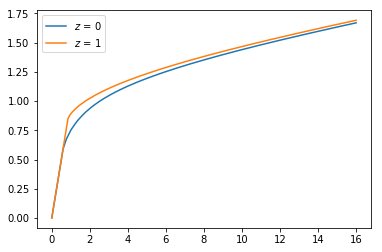

In [9]:
for z in [0, 1]:
    plt.plot(ifp.a_grid, c[:, z], label=f"$z$ = {z}")

plt.legend()
plt.show()

### Endogenous Grid Method

In [10]:
@njit
def K_EGM(c, ifp):
    """
    The EGM operator K.

    Iteration with this operator corresponds to the endogenous
    grid method. Computes and returns the updated consumption 
    policy values on the grid pairs (a, z).
    """

    a_grid, k_grid = ifp.a_grid, ifp.k_grid

    c_new = np.empty_like(c)
    for z in [0, 1]:
        for i in range(len(k_grid)):
            k = k_grid[i]

            c_new[i, z] = k_z_optimal_c(k, z, c, ifp)

        # update policy
        a_new = c_new[:, z] + k_grid
        c_new[:, z] = interp(a_new, c_new[:, z], a_grid)

        # interp does flat extrapolation at the lower end of a_grid
        # need to cap the optimal consumption using a
        c_new[:, z] = np.minimum(c_new[:, z], a_grid)

    return c_new

In [11]:
c = solve_model(ifp, K_EGM)

Error at iteration 4 is 0.7414717830213169.
Error at iteration 8 is 0.20212130305662912.
Error at iteration 12 is 0.08988258095225099.
Error at iteration 16 is 0.048796148377543425.
Error at iteration 20 is 0.029331572574590625.
Error at iteration 24 is 0.018625728243318207.
Error at iteration 28 is 0.012159280678397888.
Error at iteration 32 is 0.008012801071561881.
Error at iteration 36 is 0.005256095580385756.
Error at iteration 40 is 0.00339308544236383.
Error at iteration 44 is 0.002136575504947391.
Error at iteration 48 is 0.0013043799434557801.

Converged in 51 iterations.


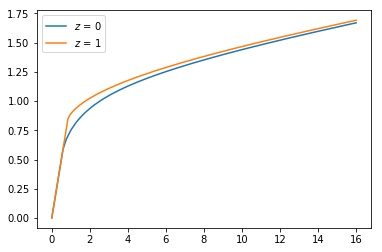

In [12]:
for z in [0, 1]:
    plt.plot(ifp.a_grid, c[:, z], label=f"$z$ = {z}")

plt.legend()
plt.show()

### Compare the speed of `K_euler` and `K_EGM`

In [13]:
%%time

c = solve_model(ifp, K_euler, verbose=False);

CPU times: user 401 ms, sys: 14 ms, total: 415 ms
Wall time: 368 ms


In [14]:
%%time

c = solve_model(ifp, K_EGM, verbose=False);

CPU times: user 59.8 ms, sys: 1.99 ms, total: 61.8 ms
Wall time: 61.3 ms


### High Interest Rate

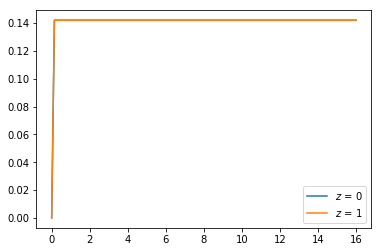

In [15]:
ifp = IFP(r=0.06)
c = solve_model(ifp, K_EGM, max_iter=1000, verbose=False);

for z in [0, 1]:
    plt.plot(ifp.a_grid, c[:, z], label=f"$z$ = {z}")

plt.legend()
plt.show()